In [67]:
import pandas as pd
import pyarrow.dataset as ds
from pathlib import Path
from chronos import Chronos2Pipeline
import numpy as np
from pykrige.ok import OrdinaryKriging

# Path to the directory
parquet_dir = Path("tester.parquet")

dataset = ds.dataset(parquet_dir, format="parquet")
df = dataset.to_table().to_pandas()
df.head()


BBOX = {
    "lat_min": 52.3383,
    "lat_max": 52.6755,
    "lon_min": 13.0884,
    "lon_max": 13.7612,
}


In [68]:
# ----------------------------
# Convert timestamp to datetime
# ----------------------------
df['timestamp'] = pd.to_datetime(df['timestamp'])

# ----------------------------
# Aggregate P2 by sensor location and day
# ----------------------------
df['date'] = df['timestamp'].dt.floor('D')

# Ensure P2 is float before aggregation
df['P2'] = pd.to_numeric(df['P2'], errors='coerce')  # invalid parsing becomes NaN

# Create date column for daily aggregation
df['date'] = pd.to_datetime(df['timestamp']).dt.floor('D')

# Aggregate by sensor location and day
daily_avg = (
    df.groupby(['lat', 'lon', 'date', 'sensor_id'], as_index=False)['P2']
      .mean()
      .rename(columns={'P2': 'target'})  # Chronos expects 'target'
)

# Drop any rows where aggregation produced NaN (if all values were NaN that day)
daily_avg = daily_avg.dropna(subset=['target']).reset_index(drop=True)

# ---------------------------
print(daily_avg.head())

# Use sensor_id as item_id
daily_avg['item_id'] = daily_avg['sensor_id']

# Build mapping for kriging
location_dict = daily_avg.groupby('item_id')[['lat','lon']].first().apply(tuple, axis=1).to_dict()

# Keep only relevant columns -- CHRONOS DF
daily_df = daily_avg[['date', 'item_id', 'target']].rename(columns={'date':'timestamp'})

print(daily_df.columns)



           lat          lon       date sensor_id    target
0  52.34112525  13.40416440 2025-11-06     88152  3.073469
1  52.34112525  13.40416440 2025-11-07     88152  5.041851
2  52.34112525  13.40416440 2025-11-08     88152  7.573447
3  52.34112525  13.40416440 2025-11-09     88152  6.755453
4  52.34112525  13.40416440 2025-11-10     88152  5.223844
Index(['timestamp', 'item_id', 'target'], dtype='object')


In [69]:
# ----------------------------
# Config
# ----------------------------
FORECAST_DAYS = 3
QUANTILES = [0.1, 0.5, 0.9]

# Ensure correct columns for Chronos
daily_df = daily_df.rename(columns={"sensor_id":"item_id", "date":"timestamp"})
daily_df['timestamp'] = pd.to_datetime(daily_df['timestamp'])

# ----------------------------
# Pivot to wide format if needed
# ----------------------------
df_wide = daily_df.pivot(index="timestamp", columns="item_id", values="target").asfreq("D")

# Filter sensors with enough data
sensor_counts = df_wide.notna().sum()
valid_sensors = sensor_counts[sensor_counts >= 10].index
df_wide = df_wide[valid_sensors]

# ----------------------------
# Convert back to long format for Chronos
# ----------------------------
train_long = df_wide.reset_index().melt(id_vars="timestamp", var_name="item_id", value_name="target")

# ----------------------------
# Load Chronos model
# ----------------------------
pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2", device_map="cuda")

# ----------------------------
# Predict
# ----------------------------
pred_df = pipeline.predict_df(
    train_long,
    prediction_length=FORECAST_DAYS,
    quantile_levels=QUANTILES,
    id_column="item_id",
    timestamp_column="timestamp",
    target="target"
)


In [70]:
pred_df.head()

,item_id,timestamp,target_name,predictions,0.1,0.5,0.9
0,17686,2025-11-17,target,10.966414,1.264815,10.966414,26.330803
1,17686,2025-11-18,target,10.899801,-1.081757,10.899801,30.678040
2,17686,2025-11-19,target,10.735532,-1.785576,10.735532,34.365593
3,18376,2025-11-17,target,10.292163,0.237907,10.292163,26.181988
4,18376,2025-11-18,target,10.039211,-2.310186,10.039211,30.358080


In [71]:
# pred_df is your predictions DataFrame
# location_dict maps item_id -> (lat, lon)

# 1. Map lat/lon from location_dict
pred_df[['lat', 'lon']] = pred_df['item_id'].map(lambda x: location_dict.get(x, (None, None))).apply(pd.Series)

# 2. Optionally drop rows where mapping failed
pred_df = pred_df.dropna(subset=['lat','lon'])

# 3. Rename prediction column to 'value' for clarity in kriging script
pred_df = pred_df.rename(columns={"predictions": "value"})

# 4. Add is_sensor flag
pred_df["is_sensor"] = True

# Now pred_df has exactly the columns your kriging script expects:
# ['item_id', 'timestamp', 'target_name', 'value', '0.1', '0.5', '0.9', 'lat', 'lon', 'is_sensor']
# You can pass it as `data` in your kriging snippet
data = pred_df.drop(columns=['target_name', '0.5']).copy()


### FILTERING - Applied math... so it needs to be realisitc

# Keep only the latest timestamp
latest_ts = data['timestamp'].max()
threshold = 100

# Remove negative values (PM2.5 can’t be < 0)
data = data[data['value'] >= 0]

# Remove overly uncertain predictions
data = data[(data['0.9'] - data['0.1']) <= threshold]

# Keep only the latest timestamp
data = data[data['timestamp'] == latest_ts].copy()

# Remove the extreme top sensors (optional, e.g., top 2%)
upper_cutoff = data['value'].quantile(0.98)
data = data[data['value'] <= upper_cutoff].copy()

# Winsorize remaining values for smoother kriging
lower_val = np.percentile(data['value'], 1)
upper_val = np.percentile(data['value'], 99)
data['value'] = data['value'].clip(lower=lower_val, upper=upper_val)



data.head()

,item_id,timestamp,value,0.1,0.9,lat,lon,is_sensor
2,17686,2025-11-19,10.735532,-1.785576,34.365593,52.538,13.266,True
5,18376,2025-11-19,9.635254,-3.257966,33.922165,52.624,13.544,True
8,18473,2025-11-19,8.273203,-2.012773,25.520607,52.408,13.500,True
14,18879,2025-11-19,9.065143,-0.937756,28.493189,52.378,13.404,True
17,18983,2025-11-19,4.596789,-0.919532,15.181215,52.552,13.436,True


In [72]:
data.shape

(122, 8)

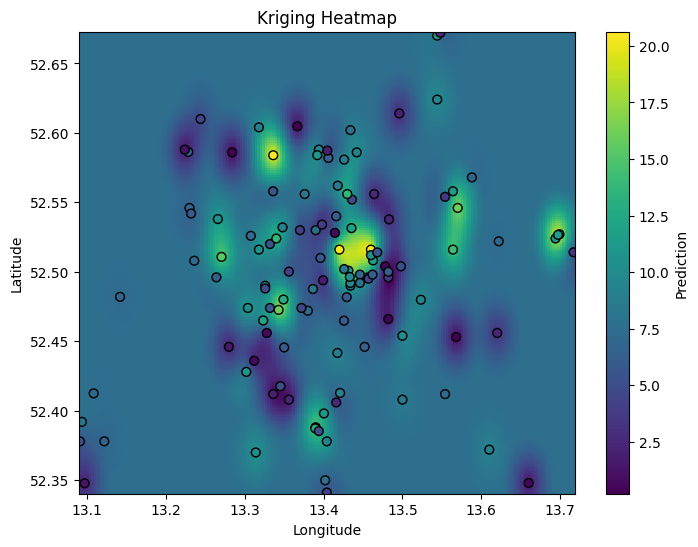

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging

# Extract coordinates and z-values
lon = data["lon"].astype(float).values
lat = data["lat"].astype(float).values
z = data["value"].astype(float).values

# 1. Create a regular grid in geographic coordinates
lon_grid = np.linspace(lon.min(), lon.max(), 200)
lat_grid = np.linspace(lat.min(), lat.max(), 200)
Lon, Lat = np.meshgrid(lon_grid, lat_grid)

# 2. Fit ordinary kriging
#    pykrige expects 1D arrays for coordinates
OK = OrdinaryKriging(
    lon, lat, z,
    variogram_model='spherical',  # good default for environmental data
    verbose=False,
    enable_plotting=False
)

# 3. Compute kriging on the grid
Z_kriged, ss = OK.execute('grid', lon_grid, lat_grid)

# 4. Plot heatmap
plt.figure(figsize=(8, 6))
plt.pcolormesh(Lon, Lat, Z_kriged, shading="auto")
plt.scatter(lon, lat, c=z, edgecolor="black", s=40)
plt.colorbar(label="Prediction")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Kriging Heatmap")
plt.show()


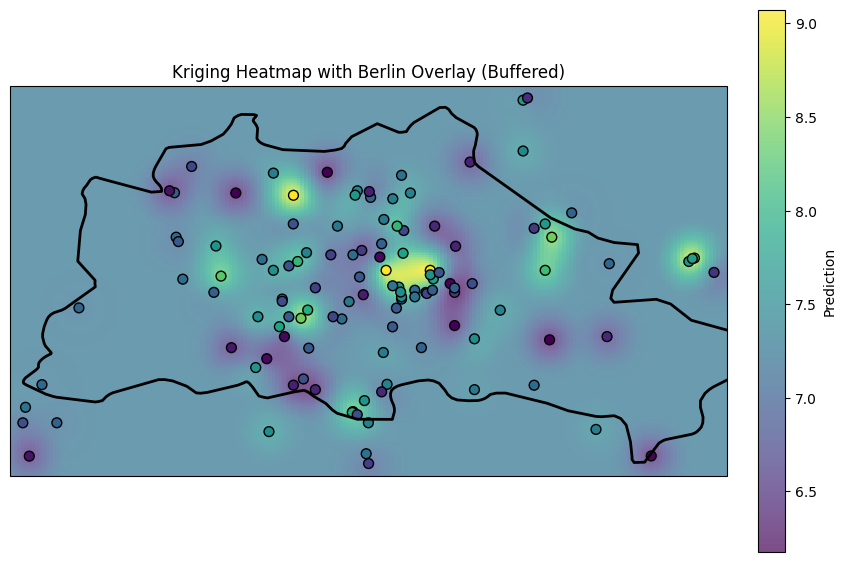

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

# ----------------------------
# 1. Extract coordinates and values
# ----------------------------
lon = data["lon"].astype(float).values
lat = data["lat"].astype(float).values
z = data["value"].astype(float).values

# ----------------------------
# 2. Define buffer and create grid
# ----------------------------
buffer = 0.01  # ~0.01 degrees (~1 km) buffer around sensor bounding box
lon_min, lon_max = lon.min() - buffer, lon.max() + buffer
lat_min, lat_max = lat.min() - buffer, lat.max() + buffer

lon_grid = np.linspace(lon_min, lon_max, 200)
lat_grid = np.linspace(lat_min, lat_max, 200)
Lon, Lat = np.meshgrid(lon_grid, lat_grid)

# ----------------------------
# 3. Fit kriging
# ----------------------------
OK = OrdinaryKriging(lon, lat, z, variogram_model='spherical', verbose=False, enable_plotting=False)
Z_kriged, ss = OK.execute('grid', lon_grid, lat_grid)

# ----------------------------
# 4. Load Berlin border
# ----------------------------
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_1_states_provinces')
reader = shpreader.Reader(shpfilename)
for record in reader.records():
    if record.attributes['name'] == 'Berlin':
        berlin_geom = record.geometry
        break

# ----------------------------
# 5. Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Heatmap
im = ax.pcolormesh(Lon, Lat, Z_kriged, shading='auto', cmap='viridis', alpha=0.7, transform=ccrs.PlateCarree())

# Sensor points
ax.scatter(lon, lat, c=z, edgecolor='black', s=50, transform=ccrs.PlateCarree(), cmap='viridis')

# Berlin border
ax.add_geometries([berlin_geom], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=2)

# Shrunk colorbar
plt.colorbar(im, ax=ax, label="Prediction", fraction=0.035, pad=0.04)

ax.set_title("Kriging Heatmap with Berlin Overlay (Buffered)")
plt.show()


In [83]:
print("Sensor lon/lat range:", lon.min(), lon.max(), lat.min(), lat.max())
print("Berlin geometry bounds:", berlin_geom.bounds)

Sensor lon/lat range: 13.0912292 13.71683568 52.34112525 52.672
Berlin geometry bounds: (13.091635369676567, 52.34202505111517, 13.750923293075516, 52.66355581315025)
